# Machine Learning with Python

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
sun = pd.read_csv('sunspots.csv')

In [71]:
spots = sun['Monthly_Spots']

In [72]:
from sklearn.linear_model import Ridge
lm = Ridge(alpha=0.1)

In [73]:
from sklearn.metrics import r2_score

### Exercise

Explore using different lag values to supply forecasting features for this dataset. Can we predict further into the future?

In [74]:
n_lags = 100
shifts = np.arange(1,n_lags+1)
features = {'lag_{}'.format(i): spots.shift(i) for i in shifts}
features = pd.DataFrame(features)
features

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,104.3,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,116.7,104.3,96.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92.8,116.7,104.3,96.7,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3260,7.5,6.1,5.8,0.2,5.2,1.5,0.2,6.2,1.5,0.5,...,60.9,96.1,56.8,87.6,76.5,93.7,94.8,100.1,92.0,96.5
3261,0.6,7.5,6.1,5.8,0.2,5.2,1.5,0.2,6.2,1.5,...,78.3,60.9,96.1,56.8,87.6,76.5,93.7,94.8,100.1,92.0
3262,14.4,0.6,7.5,6.1,5.8,0.2,5.2,1.5,0.2,6.2,...,107.3,78.3,60.9,96.1,56.8,87.6,76.5,93.7,94.8,100.1
3263,34.0,14.4,0.6,7.5,6.1,5.8,0.2,5.2,1.5,0.2,...,120.2,107.3,78.3,60.9,96.1,56.8,87.6,76.5,93.7,94.8


In [75]:
X_train = features[n_lags:2000]
X_test = features[2000:]

y_train = spots[n_lags:2000]
y_test = spots[2000:]

In [76]:
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

In [77]:
r2_score(y_test,y_pred)

0.8869245745092247

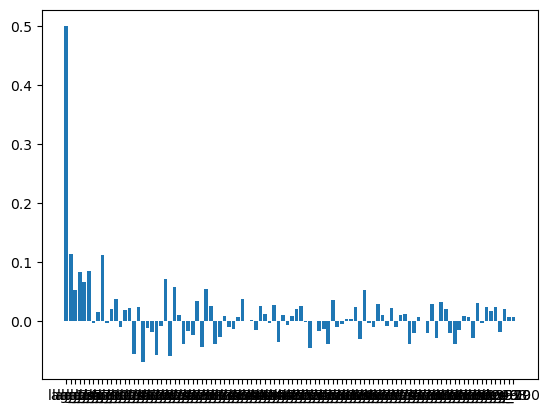

In [78]:
plt.bar(X_train.columns,lm.coef_)
plt.show()

In [79]:
def rolling_predict(model,start,n) :
    predictions = []
    current_features = start
    for i in range(n):
        current_pred = model.predict(current_features.to_frame().T)
        predictions.append(current_pred[0])
        next_features = current_features.shift()
        next_features[0] = current_pred
        current_features = next_features
    return predictions

In [80]:
y_rolled = rolling_predict(lm, X_test.iloc[0], len(X_test))

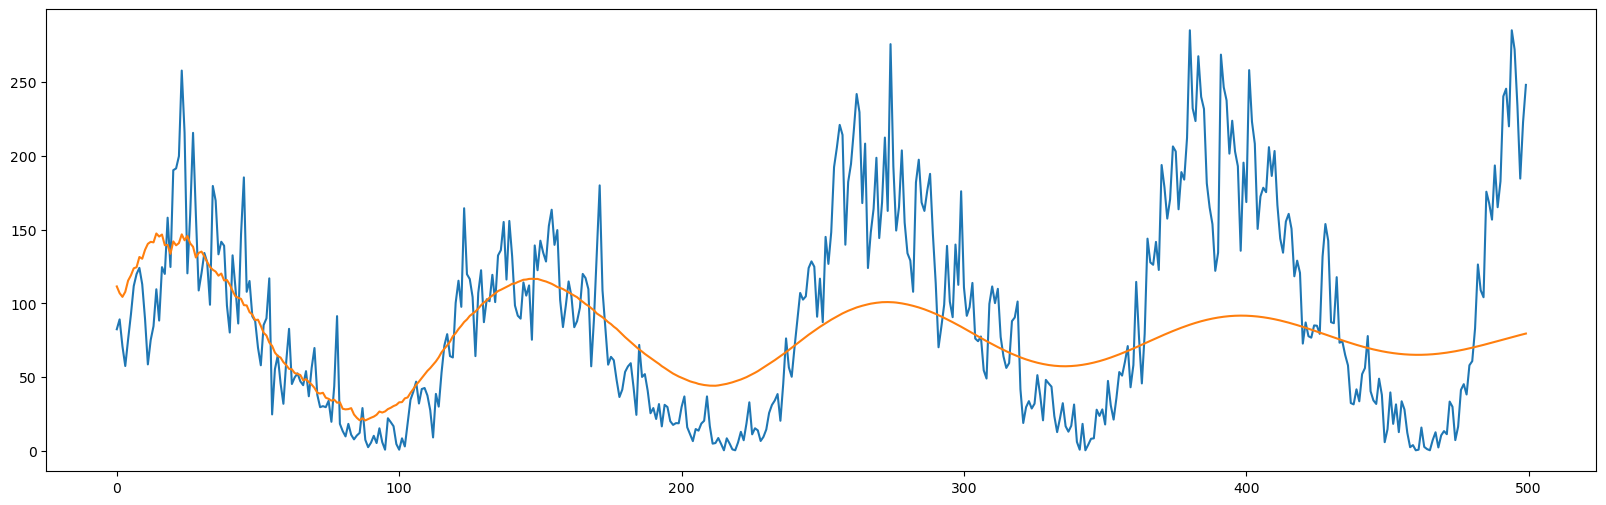

In [81]:
plt.figure(figsize = (20, 6))
plt.plot(np.arange(0,500),y_test[:500])
plt.plot(np.arange(0,500),y_rolled[:500])
plt.show()

In [82]:
r2_score(y_test[:500],y_rolled[:500])

0.3004327818506023

It's working better but we may be able to balance the coefficients more - let's try censoring the `lag_1` feature.

In [83]:
lm.fit(X_train.iloc[:,1:],y_train)
y_pred = lm.predict(X_test.iloc[:,1:])

In [84]:
r2_score(y_test,y_pred)

0.8520995803199356

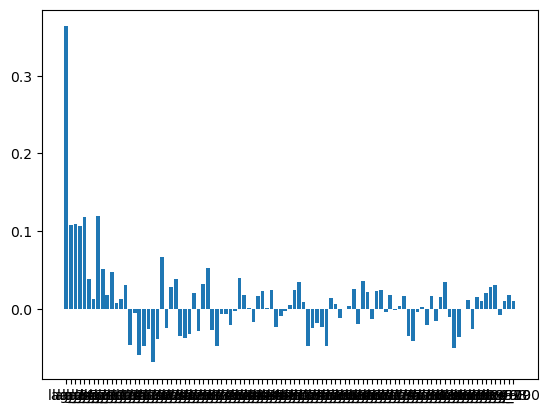

In [85]:
plt.bar(X_train.columns[1:],lm.coef_)
plt.show()

In [86]:
y_rolled = rolling_predict(lm, X_test.iloc[0,1:], len(X_test))

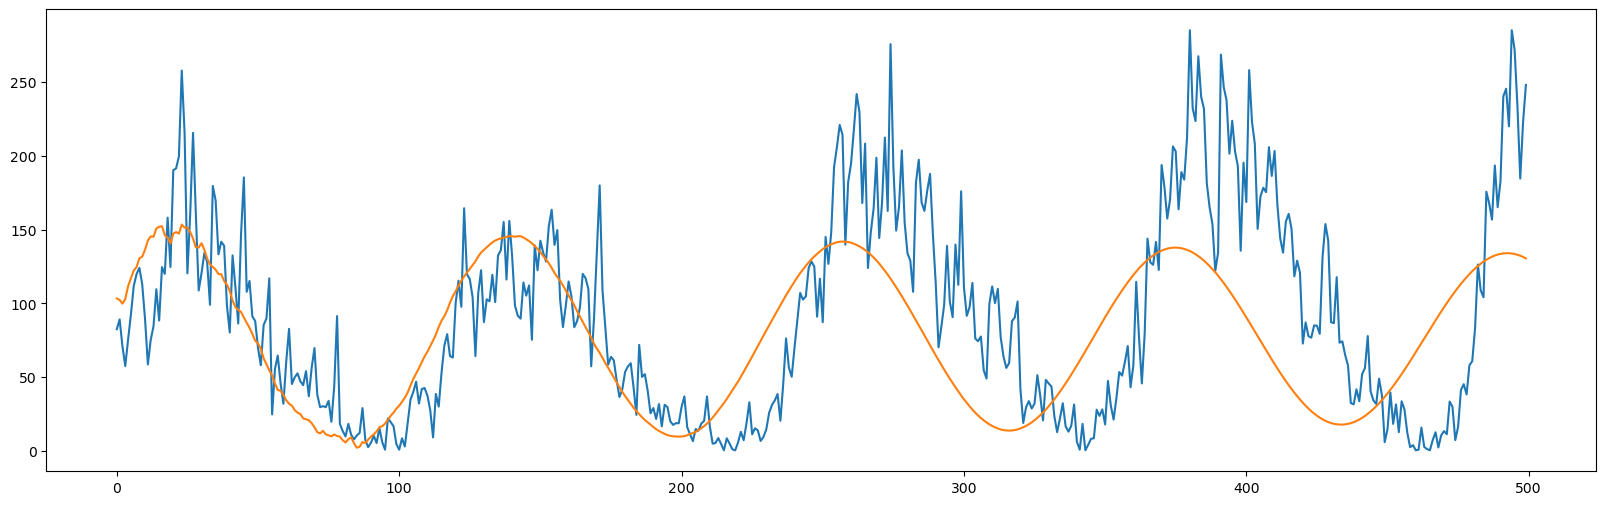

In [87]:
plt.figure(figsize = (20, 6))
plt.plot(np.arange(0,500),y_test[:500])
plt.plot(np.arange(0,500),y_rolled[:500])
plt.show()

In [88]:
r2_score(y_test[:500],y_rolled[:500])

0.3332768595916069

The oscillations are sustained much more, but the period is no longer quite correct.


Would a sliding window help in producing better predictions?

In [89]:
from numpy.lib.stride_tricks import sliding_window_view
def smooth(x,window_size) :
  v = sliding_window_view(x,window_size)
  return v.mean(axis=-1)

In [90]:
window = 25
spots_smoothed = smooth(spots,window)

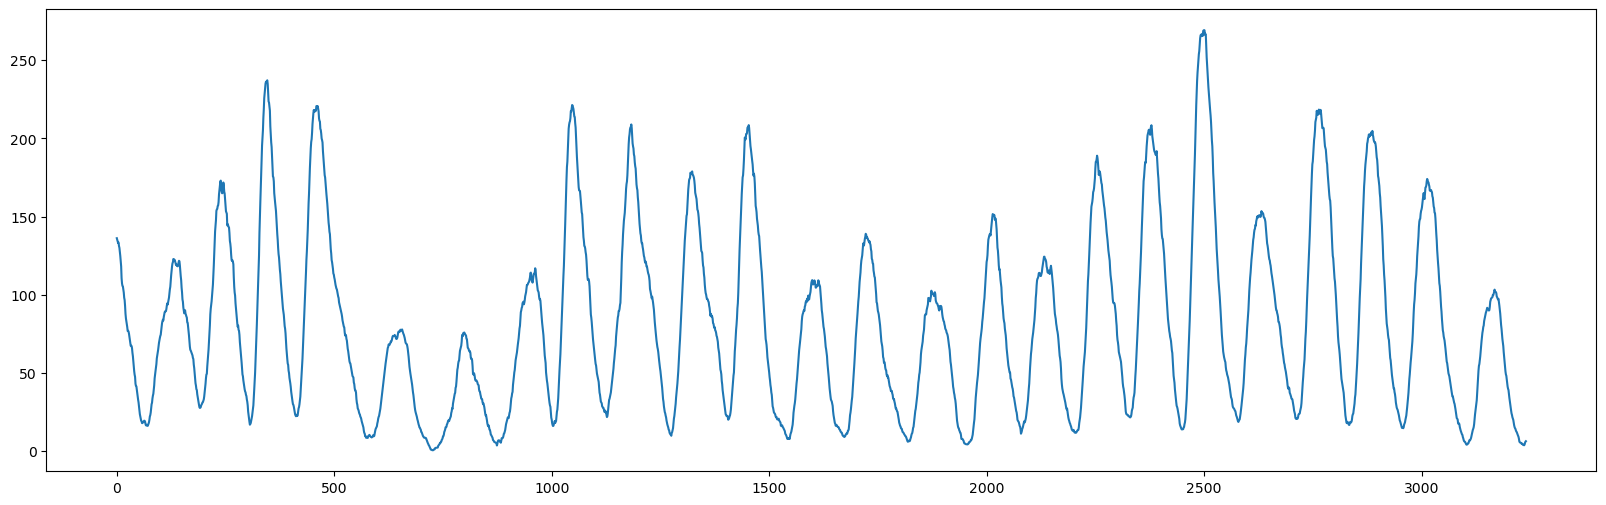

In [91]:
plt.figure(figsize = (20, 6))
plt.plot(np.arange(0,len(spots_smoothed)),spots_smoothed)
plt.show()

We can construct a supplementary set of lagged features based on the smoothed data.

In [92]:
spots_smoothed = pd.Series(spots_smoothed)
shifts = np.arange(1,n_lags+1,window)
features2 = {'sm_lag_{}'.format(i): spots_smoothed.shift(i) for i in shifts}
features2 = pd.DataFrame(features2)
features2

,sm_lag_1,sm_lag_26,sm_lag_51,sm_lag_76
0,NaN,NaN,NaN,NaN
1,136.128,NaN,NaN,NaN
2,135.160,NaN,NaN,NaN
3,134.008,NaN,NaN,NaN
4,133.100,NaN,NaN,NaN
...,...,...,...,...
3236,4.024,20.860,74.452,97.572
3237,3.700,19.912,71.632,97.828
3238,4.144,18.036,69.632,98.156
3239,5.308,16.448,67.140,98.428


Remember that the smoothing produces a shorter sequence than the original series, so we need to be careful about matching these up correctly.

In [93]:
features.shape

(3265, 100)

In [94]:
features2.shape

(3241, 4)

In [95]:
X = pd.concat([features.iloc[window-1:,1:].reset_index(drop=True),
               features2.iloc[:,1:]],
               axis=1)

In [96]:
X_train = X.iloc[n_lags:2000]
X_test = X.iloc[2000:]

y_train = spots[window-1:][n_lags:2000]
y_test = spots[window-1:][2000:]

In [97]:
X_train.head()

,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,...,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,sm_lag_26,sm_lag_51,sm_lag_76
100,78.0,73.3,80.5,71.7,71.7,62.8,104.2,64.5,73.3,75.0,...,110.5,84.5,101.2,94.0,75.5,72.5,116.7,18.472,32.808,79.304
101,78.3,78.0,73.3,80.5,71.7,71.7,62.8,104.2,64.5,73.3,...,99.7,110.5,84.5,101.2,94.0,75.5,72.5,20.020,31.128,76.768
102,81.7,78.3,78.0,73.3,80.5,71.7,71.7,62.8,104.2,64.5,...,39.2,99.7,110.5,84.5,101.2,94.0,75.5,22.128,28.512,76.916
103,83.3,81.7,78.3,78.0,73.3,80.5,71.7,71.7,62.8,104.2,...,38.7,39.2,99.7,110.5,84.5,101.2,94.0,22.980,25.980,76.428
104,85.0,83.3,81.7,78.3,78.0,73.3,80.5,71.7,71.7,62.8,...,47.5,38.7,39.2,99.7,110.5,84.5,101.2,24.648,23.580,75.068


In [98]:
lm.fit(X_train,y_train)
y_pred = lm.predict(X_test)

In [99]:
r2_score(y_test,y_pred)

0.8563396477519969

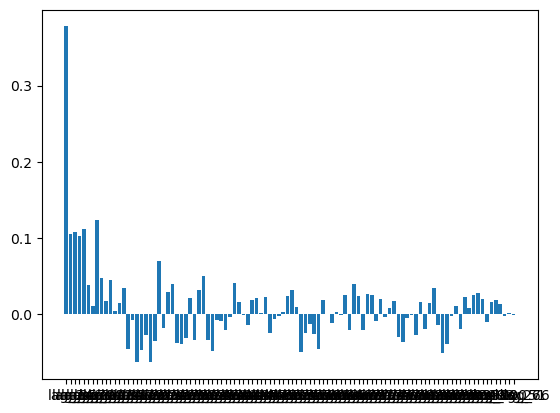

In [100]:
plt.bar(X_train.columns,lm.coef_)
plt.show()

In [101]:
y_rolled = rolling_predict(lm, X_test.iloc[0], len(X_test))

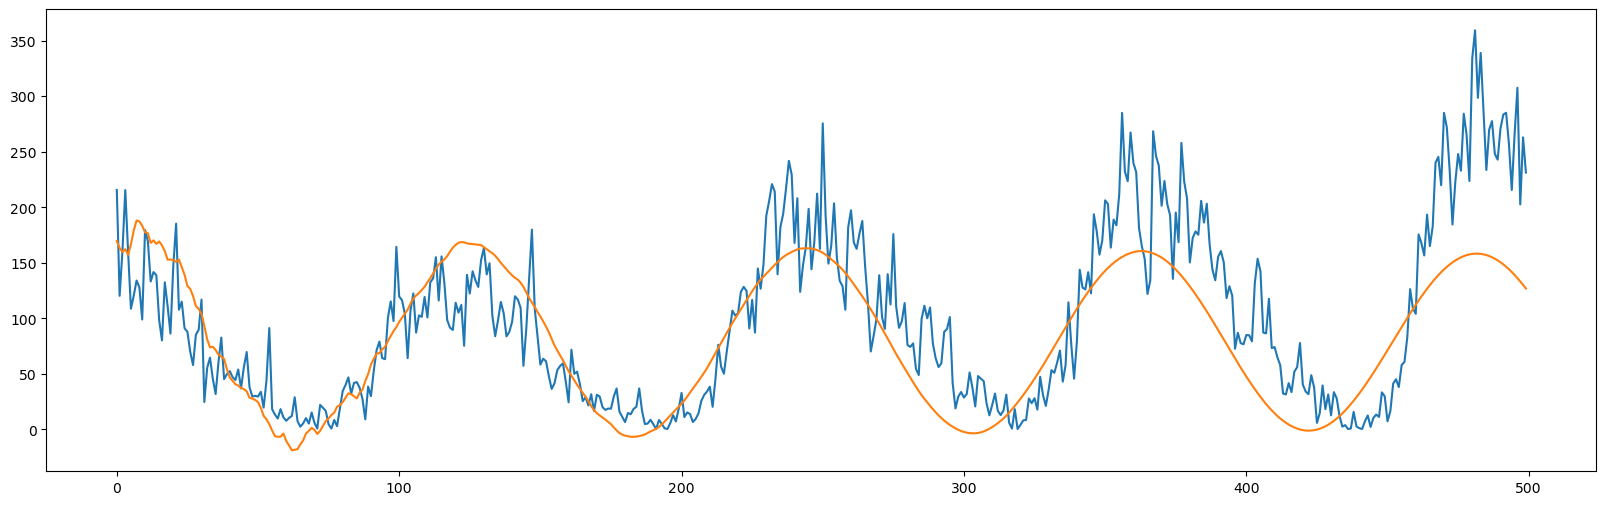

In [102]:
plt.figure(figsize = (20, 6))
plt.plot(np.arange(0,500),y_test[:500])
plt.plot(np.arange(0,500),y_rolled[:500])
plt.show()

In [103]:
r2_score(y_test[:500],y_rolled[:500])

0.5891277218360491

Much better!